In [1]:
import os
import json
import pandas as pd
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt
import csv

# Phase Extraction
from f_dacm import dacm
from f_noise_RM import remove_noise

from scipy.signal import butter, sosfiltfilt, filtfilt,lfilter


In [2]:
# Pembacaan Parameter Dataset
filename = "parameter.json"
with open(filename, 'r') as f:
    params = json.load(f)

In [3]:
# Function to read dataset.csv
def read_csv(filepath, row=True):
    df = pd.read_csv(filepath, header=None)
    if row: # row data
        data = df.T.values.tolist()[0]
    else: # comma-separated column data
        data = df.values.tolist()[0]
    return data
def read_raw(filepath):
    raw = []
    with open(filepath) as f:
        # read all lines into list of string
        lines = f.readlines()
        for line in lines:
            # remove leading and trailing white spaces and split by comma delimiter
            raw += line.strip().split(',')
    raw = [complex(s.replace('i', 'j')) for s in raw]
    return raw

In [4]:
dataset_folder = 'E:\Read-Dataset-Publik-Radar-FMCW-\Children Dataset'
radar_raw_folder = os.path.join(dataset_folder, "FMCW Radar\Rawdata")
radar_vital_folder = os.path.join(dataset_folder, "FMCW Radar\Heart Rate & Breathing Rate")
ref_raw_folder = os.path.join(dataset_folder, "Nihon Kohden\Heartbeat & Breathing Waveform")
ref_vital_folder = os.path.join(dataset_folder, "Nihon Kohden\Heart Rate & Breathing Rate")
subject_stats_folder = os.path.join(dataset_folder, "Participant\Human Data")
subject_photo_folder = os.path.join(dataset_folder, "Participant\Picture")

# Subject
subject_id = 7
radar_raw_path = os.path.join(radar_raw_folder, f"Rawdata_{subject_id}.csv")
raw_data = read_raw(radar_raw_path)## Pemanggilan Dataset Dari Folder 
# Merubah data list ke Array 
raw_data = np.asarray(raw_data, dtype=complex)
n_samples = raw_data.shape[0]//params['n_rx']
# print(raw_data.shape[0])
raw_radar = raw_data.reshape(params['n_rx'],n_samples, order='C')
raw_new = raw_radar.reshape((params['n_rx'],params['n_adc']*params['n_chirp'],-1), order='F')
#read heart rate (HR) and breath rate (BR) reading from reference device
ref_hr_path = os.path.join(ref_vital_folder, f"Ref_Heart_{subject_id}.csv")
ref_br_path = os.path.join(ref_vital_folder, f"Ref_Breath_{subject_id}.csv")
# Radar Paper
# read heart rate (HR) and breath rate (BR) estimation from radar
hr_radar_path = os.path.join(radar_vital_folder, f"Heart_{subject_id}.csv")
br_radar_path = os.path.join(radar_vital_folder, f"Breath_{subject_id}.csv")
#df_radar = pd.read_csv(hr_radar_path, header=None)
hr_radar = read_csv(hr_radar_path, row=True)
br_radar = read_csv(br_radar_path, row=True)
#df_hr = pd.read_csv(ref_hr_path, header=None)
hr = read_csv(ref_hr_path, row=False)
br = read_csv(ref_br_path, row=False)
# Waveform 
radar_br_wave_path = os.path.join(ref_raw_folder, f"Ref_Breath_Wave_{subject_id}.csv")
radar_hr_wave_path = os.path.join(ref_raw_folder, f"Ref_Heart_Wave_{subject_id}.csv")
br_wave =np.array(read_csv(radar_br_wave_path))
hr_wave =np.array(read_csv(radar_hr_wave_path,row=True))

## Extract Target Signal to CSV

In [5]:
# for i in range(1, 51):
#     radar_br_wave_path = os.path.join(ref_raw_folder, f"Ref_Breath_Wave_{i}.csv")
#     radar_hr_wave_path = os.path.join(ref_raw_folder, f"Ref_Heart_Wave_{i}.csv")
#     br_wave =np.array(read_csv(radar_br_wave_path)).reshape(1,-1)
#     hr_wave =np.array(read_csv(radar_hr_wave_path,row=True)).reshape(1,-1)
#     for j in range(4):
#         with open('br_wave.csv', 'a') as f: 
#             # Create a CSV writer object that will write to the file 'f'
#             csv_writer = csv.writer(f)
        
#             # Write all of the rows of data to the CSV file
#             csv_writer.writerows(br_wave)
#         with open('hr_wave.csv', 'a') as f: 
#             # Create a CSV writer object that will write to the file 'f'
#             csv_writer = csv.writer(f)
        
#             # Write all of the rows of data to the CSV file
#             csv_writer.writerows(hr_wave)

In [6]:
br_target = []
hr_target = []

with open('br_wave.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        br_target.append(lines)
        
with open('hr_wave.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        hr_target.append(lines)

In [7]:
br_target_array = []
hr_target_array = []
for i in range(0, 400, 2):
    br_target_array.append(br_target[i])
    hr_target_array.append(hr_target[i])
    
br_target_array = np.array(br_target_array).astype(np.int64)
hr_target_array = np.array(hr_target_array).astype(np.int64)

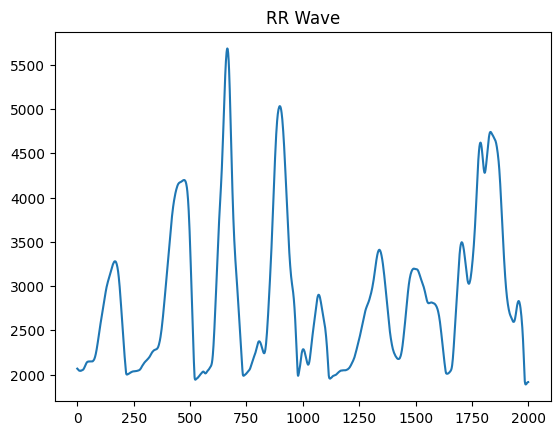

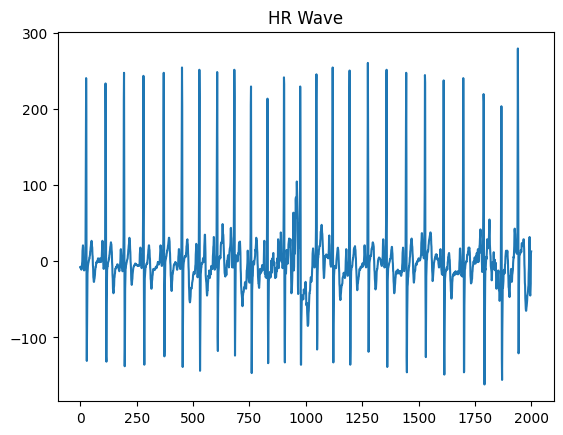

In [8]:
plt.figure(1)
plt.title("RR Wave")
plt.plot(br_target_array[0][:2000],label="RR Wave")
plt.figure(2)
plt.title("HR Wave")
plt.plot(hr_target_array[0][:2000],label="HR Wave")

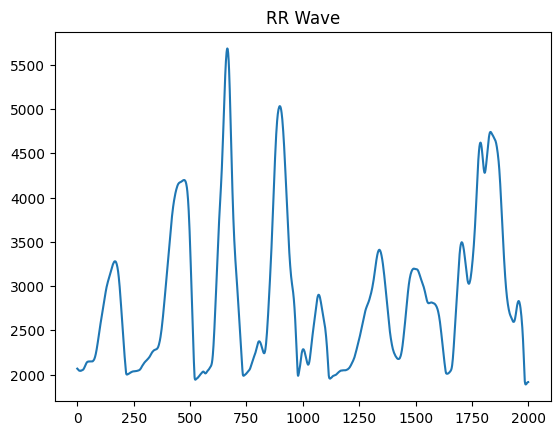

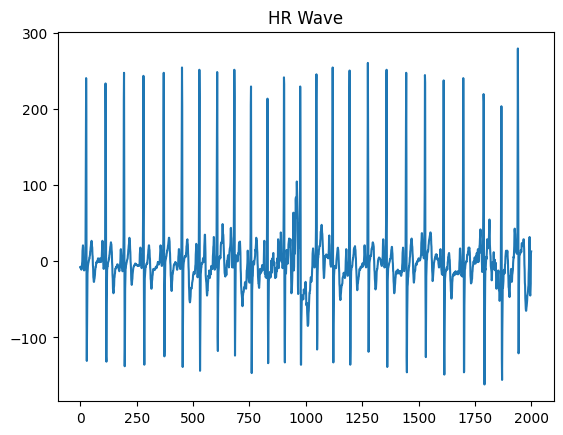

In [9]:
plt.figure(1)
plt.title("RR Wave")
plt.plot(br_target_array[0][:2000],label="RR Wave")
plt.figure(2)
plt.title("HR Wave")
plt.plot(hr_target_array[0][:2000],label="HR Wave")

## Extract Phase Signal to CSV

In [10]:
def Range_FFT(InputData):
    OutputData = np.zeros((params['n_rx'], params['n_fft'], params['data_len']), dtype=complex)
    dc_removal = np.zeros((params['n_rx'], params['n_fft']//2, params['data_len']), dtype=complex)
    for i in range(params['n_rx']):
        for j in range(params['data_len']):
            window = np.hamming(params['n_fft'])
            dc_removal[i,:,j]= InputData[i,:,j] - np.mean(InputData[i,:,j])
            OutputData[i,:,j]= fft((dc_removal[i,:,j]), n=1024)
    return OutputData

def MTI(hasil_fft):
    clutter = np.zeros((hasil_fft.shape[0], params['n_fft'], hasil_fft.shape[-1]),dtype=complex)
    OutputData = np.zeros((hasil_fft.shape[0],params['n_fft']//2, hasil_fft.shape[-1]),dtype=complex)
    alpha = 0.01
    for i in np.arange(hasil_fft.shape[0]):
        for j in np.arange(1,hasil_fft.shape[-1]):
            clutter[i,:,j] = np.dot(alpha,hasil_fft[i,:,j])+ np.dot((1-alpha),clutter[i,:,j-1])
            OutputData[i,:,j] = hasil_fft[i,np.arange(params['n_fft']//2),j]-(clutter[i,range(0, params['n_fft']//2),j])
    return OutputData

# Map Lokasinya 
def map_loc(data_mti):
    Range_Map_An1 = []
    index_max = []
    for i in range(1, params['data_len']):
        # Input data From MTI each Antenna 
        awal_an1 = data_mti[:, i] 
        abs_mti_1 = abs(awal_an1)
        peak_loc_an1 = np.argmax(abs_mti_1[25:60]) #pilih batas jarak
        rslt_peak_1 = 25 + peak_loc_an1
        if i > 1 and abs(rslt_peak_1 - index_max[-1]) == 10:
            # Jika perbedaan adalah 10, pilih peak tertinggi kedua
            abs_mti_1[peak_loc_an1] = 0  # Hilangkan peak pertama
            peak_loc_an1 = np.argmax(abs_mti_1[25:60])
            rslt_peak_1 = 25 + peak_loc_an1
        map_loc_an1 = awal_an1[rslt_peak_1]
        index_max.append(abs(rslt_peak_1))
        Range_Map_An1.append(map_loc_an1)
    return index_max, Range_Map_An1

def _butter_bandpass1(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype="band", output="sos")
    # b, a = butter(order, [low, high], btype='band')
    return sos

def _butter_bandpass2(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    # sos = butter(order, [low, high], btype="band", output="sos")
    b, a = butter(order, [low, high], btype='band')
    return b,a

def butter_bandpass_filter(signal, lowcut, highcut, fs, order):
    y1 = []
    sos = _butter_bandpass1(lowcut, highcut, fs, order=order)
    b,a = _butter_bandpass2(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(sos, signal)
    y2 = filtfilt(b,a, signal)
    map(float, y)
    # for i in range(len(y)):
    #     y1.append(y[i].astype(float))
    # y1 = [float(x) for x in y]
    return y.tolist()

In [11]:
# for i in range(1, 51):
#     radar_raw_path = os.path.join(radar_raw_folder, f"Rawdata_{i}.csv")
#     raw_data = read_raw(radar_raw_path)## Pemanggilan Dataset Dari Folder 
#     # Merubah data list ke Array 
#     raw_data = np.asarray(raw_data, dtype=complex)
#     n_samples = raw_data.shape[0]//params['n_rx']
#     # print(raw_data.shape[0])
#     raw_radar = raw_data.reshape(params['n_rx'],n_samples, order='C')
#     raw_new = raw_radar.reshape((params['n_rx'],params['n_adc']*params['n_chirp'],-1), order='F')
#     # Lakukan proses FFT
#     FFT_hasil = Range_FFT(raw_new) # hasil FFT
#     Hasil_mti = MTI(FFT_hasil)
    
#     # Hasil MTI untuk setiap antena 
#     Antena1 = Hasil_mti[0,:,:]
#     Antena2 = Hasil_mti[1,:,:]
#     Antena3 = Hasil_mti[2,:,:]
#     Antena4 = Hasil_mti[3,:,:]
    
#     map_locA1, Map_loc_An1 = np.array(map_loc(Antena1))
#     map_locA2, Map_loc_An2 = np.array(map_loc(Antena2))
#     map_locA3, Map_loc_An3 = np.array(map_loc(Antena3))
#     map_locA4, Map_loc_An4 = np.array(map_loc(Antena4))
    
#     DACM_An1 = np.array(dacm(np.array(Map_loc_An1)))
#     DACM_An2 = np.array(dacm(np.array(Map_loc_An2)))
#     DACM_An3 = np.array(dacm(np.array(Map_loc_An3)))
#     DACM_An4 = np.array(dacm(np.array(Map_loc_An4)))
    
#     # from f_noise_RM import remove_noise
#     NR_1 = remove_noise(DACM_An1)
#     NR_2 = remove_noise(DACM_An2)
#     NR_3 = remove_noise(DACM_An3)
#     NR_4 = remove_noise(DACM_An4)
    
#     low = 3/60
#     high = 55/60
#     fs = 20
#     BPF_RR1= butter_bandpass_filter(NR_1,low,high,fs,order=3)
#     BPF_RR2 = butter_bandpass_filter(NR_2,low,high,fs,order=3)
#     BPF_RR3 = butter_bandpass_filter(NR_3,low,high,fs,order=3)
#     BPF_RR4 = butter_bandpass_filter(NR_4,low,high,fs,order=3)
    
#     lowhr =60/60
#     highhr = 3.0
#     fs = 20
#     BPF_HR1 = butter_bandpass_filter(NR_1,lowhr,highhr,fs,order=6)
#     BPF_HR2 = butter_bandpass_filter(NR_2,lowhr,highhr,fs,order=6)
#     BPF_HR3 = butter_bandpass_filter(NR_3,lowhr,highhr,fs,order=6)
#     BPF_HR4 = butter_bandpass_filter(NR_4,lowhr,highhr,fs,order=6)
#     # print(BPF_HR1)
    
#     # print(butter_bandpass_filter(NR_1,low,high,fs,order=3))
#     # print(len(butter_bandpass_filter(NR_1,low,high,fs,order=3)))
#     # print(type(butter_bandpass_filter(NR_1,low,high,fs,order=3)))
#     with open('br_phase.csv', 'a') as f: 
#         # Create a CSV writer object that will write to the file 'f'
#         csv_writer = csv.writer(f)
    
#         # Write all of the rows of data to the CSV file
#         csv_writer.writerows([BPF_RR1])
#         csv_writer.writerows([BPF_RR2])
#         csv_writer.writerows([BPF_RR3])
#         csv_writer.writerows([BPF_RR4])
#     with open('hr_phase.csv', 'a') as f: 
#         # Create a CSV writer object that will write to the file 'f'
#         csv_writer = csv.writer(f)
    
#         # Write all of the rows of data to the CSV file
#         csv_writer.writerows([BPF_HR1])
#         csv_writer.writerows([BPF_HR2])
#         csv_writer.writerows([BPF_HR3])
#         csv_writer.writerows([BPF_HR4])

In [12]:
br_phase = []
hr_phase = []

with open('br_phase.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        br_phase.append(lines)
        
with open('hr_phase.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        hr_phase.append(lines)

In [13]:
br_phase_array = []
hr_phase_array = []
for i in range(0, 400, 2):
    br_phase_array.append(br_phase[i])
    hr_phase_array.append(hr_phase[i])
    
br_phase_array = np.array(br_phase_array).astype(np.float64)
hr_phase_array = np.array(hr_phase_array).astype(np.float64)

In [14]:
from sklearn.preprocessing import PowerTransformer

br_downsampled_signal = []

downsampling_factor = 37500 // 6000

for i in range(len(hr_target_array)):
    pt = PowerTransformer()
    
    br_norm = pt.fit_transform(br_target_array[i].reshape(-1, 1))
    
    br_downsampled = br_norm[::downsampling_factor]
    
    br_downsampled_signal.append(br_downsampled[:6000])
    
br_downsampled_signal = np.array(br_downsampled_signal)
print(br_downsampled_signal.shape)

(200, 6000, 1)


In [15]:
from sklearn.preprocessing import PowerTransformer

hr_downsampled_signal = []

downsampling_factor = 37500 // 6000

for i in range(len(hr_target_array)):
    pt = PowerTransformer()
    
    hr_norm = pt.fit_transform(hr_target_array[i].reshape(-1, 1))
    
    hr_downsampled = hr_norm[::downsampling_factor]
    
    hr_downsampled_signal.append(hr_downsampled[:6000])
    
hr_downsampled_signal = np.array(hr_downsampled_signal)
print(hr_downsampled_signal.shape)

(200, 6000, 1)


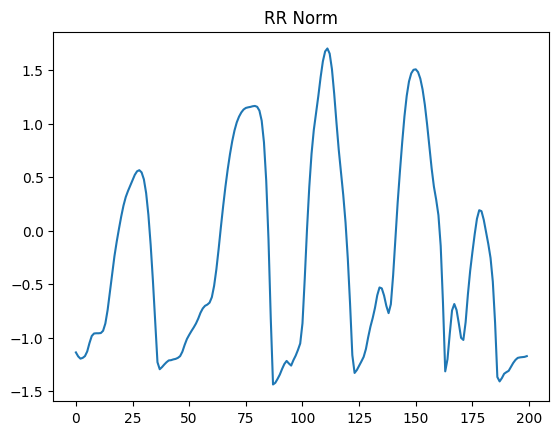

In [16]:
plt.figure(1)
plt.title("RR Norm")
plt.plot(br_downsampled_signal[0][:200],label="RR Wave")

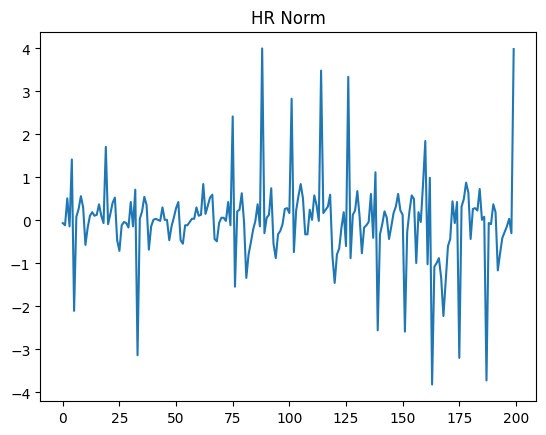

In [17]:
plt.figure(1)
plt.title("HR Norm")
plt.plot(hr_downsampled_signal[0][:200],label="RR Wave")

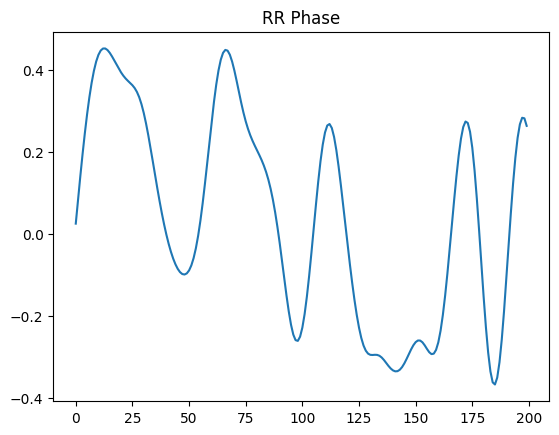

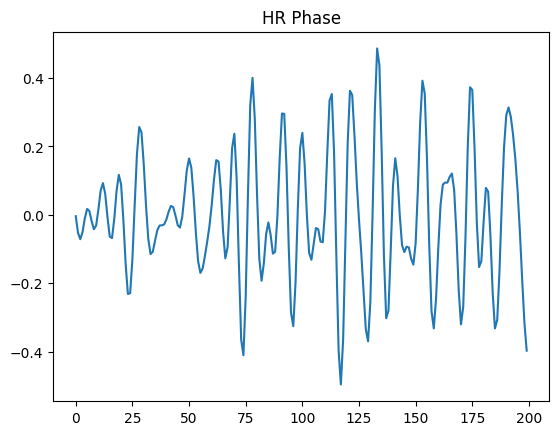

In [18]:
plt.figure(1)
plt.title("RR Phase")
plt.plot(br_phase_array[0][:200],label="RR Phase")
plt.figure(2)
plt.title("HR Phase")
plt.plot(hr_phase_array[0][:200],label="HR Phase")

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Parameter
input_shape = (5995, 1)  # Input shape dari data radar
output_shape = (6000, 1)  # Output shape untuk sinyal detak jantung

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Encoder
def build_encoder(input_shape):
    encoder_input = tf.keras.Input(shape=input_shape)
    
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling1D(pool_size=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    return models.Model(encoder_input, x, name="encoder")

# Decoder
def build_decoder(output_shape):
    decoder_input = tf.keras.Input(shape=(750, 256))  # Sesuaikan dengan output shape dari encoder
    
    x = layers.Conv1DTranspose(256, kernel_size=3, activation='relu', padding='same')(decoder_input)
    x = layers.UpSampling1D(size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv1DTranspose(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv1DTranspose(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv1DTranspose(1, kernel_size=3, activation='sigmoid', padding='same')(x)
    
    return models.Model(decoder_input, x, name="decoder")

# Autoencoder
def build_autoencoder(encoder, decoder, input_shape):
    input_layer = tf.keras.Input(shape=input_shape)
    encoded = encoder(input_layer)
    decoded = decoder(encoded)
    
    autoencoder = models.Model(input_layer, decoded, name="autoencoder")
    return autoencoder

# Membangun model
encoder = build_encoder(input_shape)
decoder = build_decoder(output_shape)
autoencoder = build_autoencoder(encoder, decoder, input_shape)

# Compile model
autoencoder.compile(optimizer='adam', loss=rmse)

# Ringkasan model
autoencoder.summary()

# Training model
# Misalkan X_train adalah data radar dan y_train adalah target sinyal detak jantung
# autoencoder.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 5995, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 750, 256)       │       125,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 6000, 1)        │       321,921 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 447,233 (1.71 MB)

 Trainable params: 445,441 (1.70 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [20]:
br_phase_array.shape

(200, 5995)

In [21]:
br_train = br_phase_array[:160]
br_test = br_phase_array[160:]
br_target_train = br_downsampled_signal[:160,:,0]
br_target_test = br_downsampled_signal[160:,:,0]
hr_train = hr_phase_array[:160]
hr_test = hr_phase_array[160:]
hr_target_train = hr_downsampled_signal[:160,:,0]
hr_target_test = hr_downsampled_signal[160:,:,0]

In [22]:
print(br_train.shape)
print(br_test.shape)
print(br_target_train.shape)
print(br_target_test.shape)
print(hr_train.shape)
print(hr_test.shape)
print(hr_target_train.shape)
print(hr_target_test.shape)

(160, 5995)
(40, 5995)
(160, 6000)
(40, 6000)
(160, 5995)
(40, 5995)
(160, 6000)
(40, 6000)


In [23]:
from tensorflow.keras.callbacks import EarlyStopping
# Training the model
br_history = autoencoder.fit(
    br_train,
    br_target_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

autoencoder.save("br_model.h5")

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.8762 - val_loss: 0.7751
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.7612 - val_loss: 0.7602
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.7598 - val_loss: 0.7393
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.7555 - val_loss: 0.7160
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.7314 - val_loss: 0.6943
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 977ms/step - loss: 0.7376 - val_loss: 0.6752
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.7202 - val_loss: 0.6597
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 961ms/step - loss: 0.7079 - val_loss: 0.6475
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.6904 - val_loss: 0.6433
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 967ms/step - loss: 0.7258 - val_loss: 0.6368
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 942ms/step - loss: 0.7060 - val_loss: 0.6307
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.7065 - val_loss: 0.6268
Epoch 13/50
4

In [ ]:
from f_fft_sinyal import fft_sinyal
def calculate_hr_rr(data_rr,data_hr):
    data_rr = np.array(data_rr)
    data_hr = np.array(data_hr)
    freq_rr, fft_rr = fft_sinyal(data_rr)
    freq_hr, fft_hr = fft_sinyal(data_hr)
    peak1 = np.argmax(fft_rr[:20])
    peak2 = np.argmax(fft_hr[:80])
    bpm_rr = freq_rr[peak1]*60
    bpm_hr = freq_hr[peak2]*60
    return bpm_rr, bpm_hr

In [ ]:
from tensorflow.keras.models import load_model

br_predict = load_model("br_model.h5", custom_objects={'rmse': rmse})
hr_predict = load_model("hr_model.h5", custom_objects={'rmse': rmse})

start = 0
counter = 0

An1_RR = np.array(br_predict(br_phase_array[160].reshape(1, -1, 1).astype(np.float64))[0,:,0])
An2_RR = np.array(br_predict(br_phase_array[161].reshape(1, -1, 1).astype(np.float64))[0,:,0])
An3_RR = np.array(br_predict(br_phase_array[162].reshape(1, -1, 1).astype(np.float64))[0,:,0])
An4_RR = np.array(br_predict(br_phase_array[163].reshape(1, -1, 1).astype(np.float64))[0,:,0])
An1_HR = np.array(hr_predict(hr_phase_array[160].reshape(1, -1, 1).astype(np.float64))[0,:,0])
An2_HR = np.array(hr_predict(hr_phase_array[161].reshape(1, -1, 1).astype(np.float64))[0,:,0])
An3_HR = np.array(hr_predict(hr_phase_array[162].reshape(1, -1, 1).astype(np.float64))[0,:,0])
An4_HR = np.array(hr_predict(hr_phase_array[163].reshape(1, -1, 1).astype(np.float64))[0,:,0])

HR_an1 =[]
HR_an2 =[]
HR_an3 =[]
HR_an4 =[]
RR_an1 =[]
RR_an2 =[]
RR_an3 =[]
RR_an4 =[]

while counter < 280:  # Changed the loop condition to run for 280 iterations
        if start + 400 < len(An1_RR):
            An1_segment_RR = An1_RR[start:start + 400]
            An2_segment_RR = An2_RR[start:start + 400]
            An3_segment_RR = An3_RR[start:start + 400]
            An4_segment_RR = An4_RR[start:start + 400]
            # HR
            An1_segment_HR = An1_HR[start:start + 400]
            An2_segment_HR = An2_HR[start:start + 400]
            An3_segment_HR = An3_HR[start:start + 400]
            An4_segment_HR = An4_HR[start:start + 400]

        else:
            An1_segment_RR = An1_RR[start:]
            An2_segment_RR = An2_RR[start:]
            An3_segment_RR = An3_RR[start:]
            An4_segment_RR = An4_RR[start:]
            #HR 
            An1_segment_HR = An1_HR[start:]
            An2_segment_HR = An2_HR[start:]
            An3_segment_HR = An3_HR[start:]
            An4_segment_HR = An4_HR[start:]
        # Select The IMF 
        Rr1,Hr1 = calculate_hr_rr(An1_segment_RR,An1_segment_HR)
        Rr2,Hr2 = calculate_hr_rr(An2_segment_RR,An2_segment_HR)
        Rr3,Hr3 = calculate_hr_rr(An3_segment_RR,An3_segment_HR)
        Rr4,Hr4 = calculate_hr_rr(An4_segment_RR,An4_segment_HR)

        # rr1,hr1 = calculate_hr_rr(u_rr1, u_hr1)
        # rr2,hr2 = calculate_hr_rr(u_rr2, u_hr2)
        # rr3,hr3 = calculate_hr_rr(u_rr3, u_hr3)
        # rr4,hr4 = calculate_hr_rr(u_rr4, u_hr4) 
       
    
        # HR_an1.append(hr1)
        # HR_an2.append(hr2)
        # HR_an3.append(hr3)
        # HR_an4.append(hr4)
        # RR_an1.append(rr1)
        # RR_an2.append(rr2)
        # RR_an3.append(rr3)
        # RR_an4.append(rr4)
        HR_an1.append(Hr1)
        HR_an2.append(Hr2)
        HR_an3.append(Hr3)
        HR_an4.append(Hr4)
        RR_an1.append(Rr1)
        RR_an2.append(Rr2)
        RR_an3.append(Rr3)
        RR_an4.append(Rr4)

        counter += 1
        start = start + 20

(1, 6000, 1)


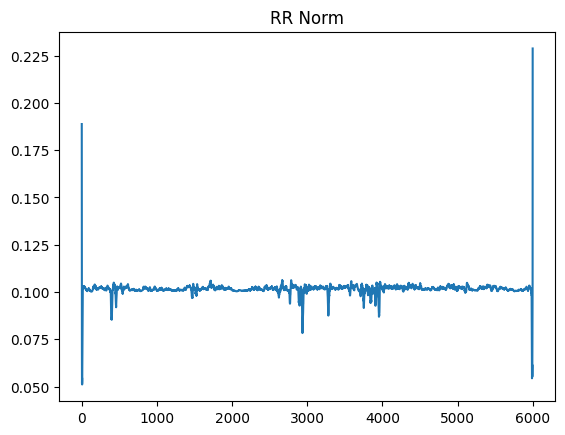

In [ ]:
plt.figure(1)
plt.title("RR Norm")
plt.plot(An1_HR,label="RR Wave")

In [64]:
# Kalman 
import numpy as np 

def kalman_filter(z_ppg1):

    Q=3**2
    R=100**2
#     Q=4**2;                    
#     R=10**2;

    count=0
    countmax=5
    imax=3

    xposteriori=z_ppg1[0]
    res = np.zeros(len(z_ppg1))
    res[0]=z_ppg1[0]
    Pposteriori=0
    hasil =[]

    for i in range (1, len(z_ppg1)):

        xpriori=xposteriori
        Ppriori=Pposteriori+Q

        S=Ppriori+R
        gain=Ppriori/S

        inn1=z_ppg1[i]-xpriori

        if (((count==countmax or i<imax) and ~np.isnan(inn1))):
            inn=inn1
            xposteriori=xpriori+gain*inn
            Pposteriori=(1-gain)*Ppriori
            if(count==countmax ):
                xposteriori=0.5*(z_ppg1[i]+xpriori)
            count=0

        else:
            count=count+1
            xposteriori=xpriori
            Pposteriori=Ppriori

        res[i]=xposteriori
        hasil.append(xposteriori)

    return hasil

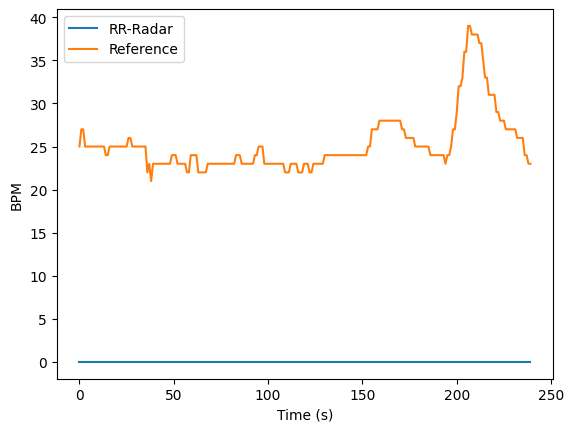

In [75]:
# RR 
RR_an1 = np.array(RR_an1)
RR_an2 = np.array(RR_an2)
RR_an3 = np.array(RR_an3)
RR_an4 = np.array(RR_an4)
TOTAL_RR = (RR_an1+RR_an2+RR_an3+RR_an4)/4 
Kalman_rr = kalman_filter(TOTAL_RR)
RR_ref = br[21:261]
plt.plot(Kalman_rr[:240],label ="RR-Radar")
plt.plot(RR_ref, label="Reference")
plt.xlabel("Time (s)")
plt.ylabel("BPM")
plt.legend()

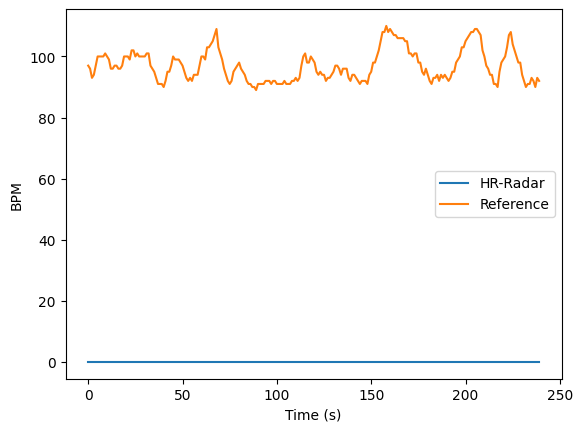

In [45]:
# RR 
HR_an1 = np.array(HR_an1)
HR_an2 = np.array(HR_an2)
HR_an3 = np.array(HR_an3)
HR_an4 = np.array(HR_an4)
TOTAL_HR = (HR_an1+HR_an2+HR_an3+HR_an4)/4 
Kalman_Hr = kalman_filter(TOTAL_HR)
HR_ref = hr[21:261]
plt.plot(Kalman_Hr[:240],label ="HR-Radar")
plt.plot(HR_ref, label="Reference")
plt.xlabel("Time (s)")
plt.ylabel("BPM")
plt.legend()